In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

import pandas as pd
import matplotlib.pyplot as plt

from aptr.database import RnaDB
from aptr.oor_distance import oor_distance

In [3]:
db = RnaDB()

0.9989153359445616 sequences remain after trimming
0.37164808677312444 sequences remain after filtering


In [14]:
# Filter to complete genomes and print count of remaining genomes

db_filtered = db.db[db.db["genome_status"] == "Complete"]
db_filtered = db.db[db.db["reference_genome"] == "Reference"]
print(len(db_filtered["genome"].unique()))

10


In [15]:
# For each genome, get the difference between max and min oor distance

best_spreads = (
    db_filtered["oor_distance"].groupby(db_filtered["genome"]).apply(lambda x: x.max() - x.min()).sort_values(ascending=False)
)
best_spreads.head(10)

genome
169963.11     0.653007
224308.43     0.488437
99287.836     0.479467
511145.12     0.471252
198214.7      0.452367
386585.154    0.411871
208964.12     0.399403
1125630.4     0.347017
871585.3      0.333057
93061.5       0.332212
Name: oor_distance, dtype: float64

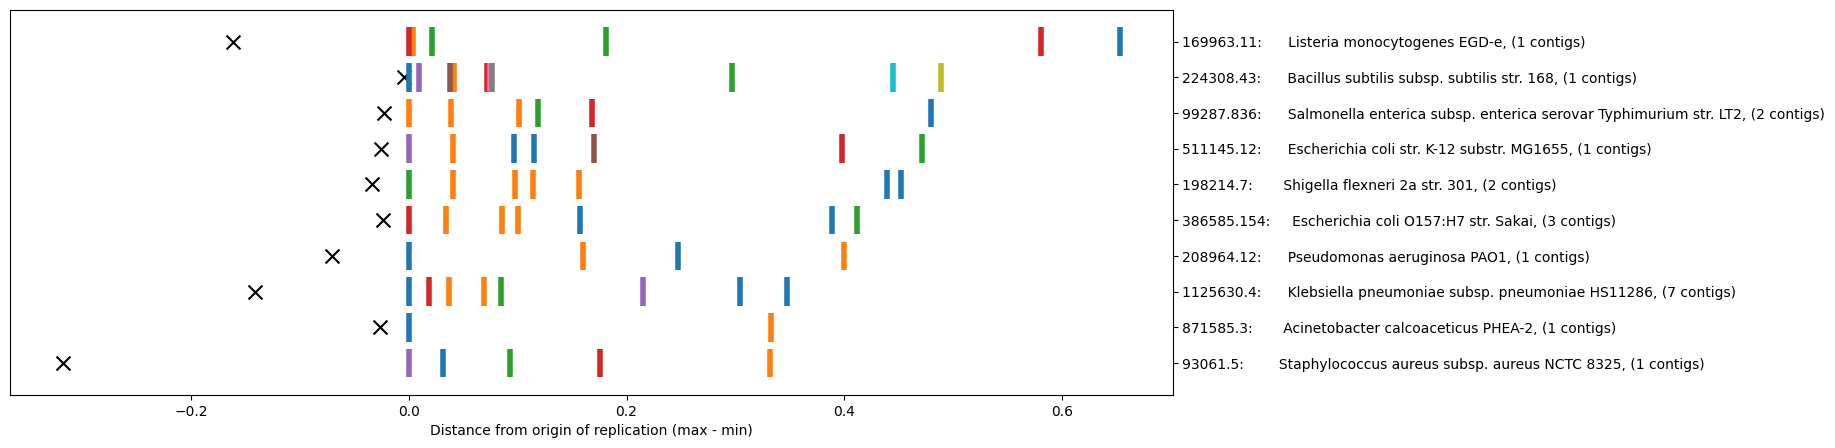

In [23]:
from matplotlib import cm
import numpy as np

N_GENOMES = min(30, len(best_spreads))

def visualize_genome(gid, height=0, dist=None, db=db):
    g = db[gid]
    colors = cm.tab10(g["md5"].astype("category").cat.codes)
    offset = g["oor_distance"].min()
    plt.vlines(g["oor_distance"] - offset, -height - 0.4, -height + 0.4, colors=colors, lw=4)
    plt.scatter(-offset, -height, color="black", s=100, marker="x")


fig, ax = plt.subplots(figsize=(15, 5))
for i, gid in enumerate(best_spreads.iloc[:N_GENOMES].index):
    visualize_genome(gid, i, best_spreads[gid])

# Yticks on the right
plt.gca().yaxis.tick_right()
plt.yticks(
    np.arange(0, -N_GENOMES, -1),
    [f"{gid}:\t{db[gid]['genome_name'].iloc[0]}, ({db[gid]['n_contigs'].iloc[0]} contigs)".expandtabs() for gid in best_spreads.index[:N_GENOMES]],
)

# X-label
plt.xlabel("Distance from origin of replication (max - min)")

plt.show()

In [7]:
db_unfiltered = RnaDB(bypass_filter=True)

0.9989153359445616 sequences remain after trimming
0.9989153359445616 sequences remain after filtering


7


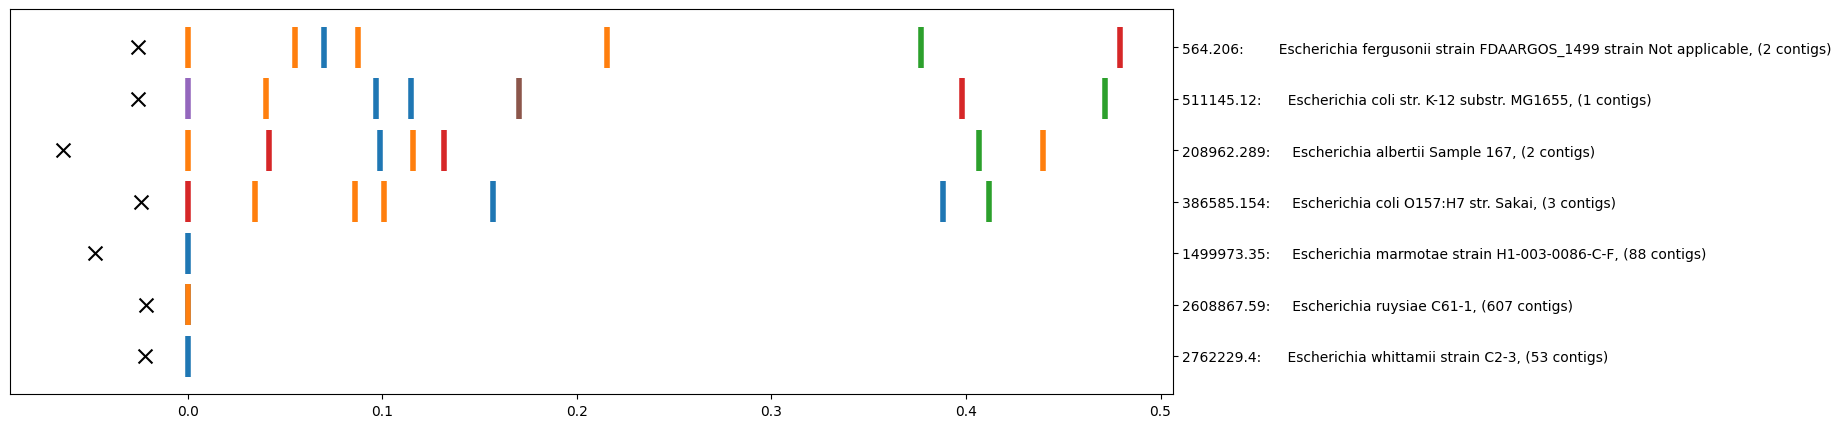

In [8]:
# Just Escherichia

# Filter to complete genomes and print count of remaining genomes
db_filtered2 = db_unfiltered.db[db_unfiltered.db["genome_name"].str.contains("Escherichia")]
print(len(db_filtered2["genome"].unique()))

# Get spreads
best_spreads2 = (
    db_filtered2["oor_distance"].groupby(db_filtered2["genome"]).apply(lambda x: x.max() - x.min()).sort_values(ascending=False)
)

# Plot
fig, ax = plt.subplots(figsize=(15, 5))
for i, gid in enumerate(best_spreads2.index):
    visualize_genome(gid, i, db_unfiltered[gid], db=db_unfiltered)

# Yticks on the right
plt.gca().yaxis.tick_right()
plt.yticks(
    np.arange(0, -len(best_spreads2), -1),
    [f"{gid}:\t{db_unfiltered[gid]['genome_name'].iloc[0]}, ({db_unfiltered[gid]['n_contigs'].iloc[0]} contigs)".expandtabs() for gid in best_spreads2.index],
)
plt.show()

2


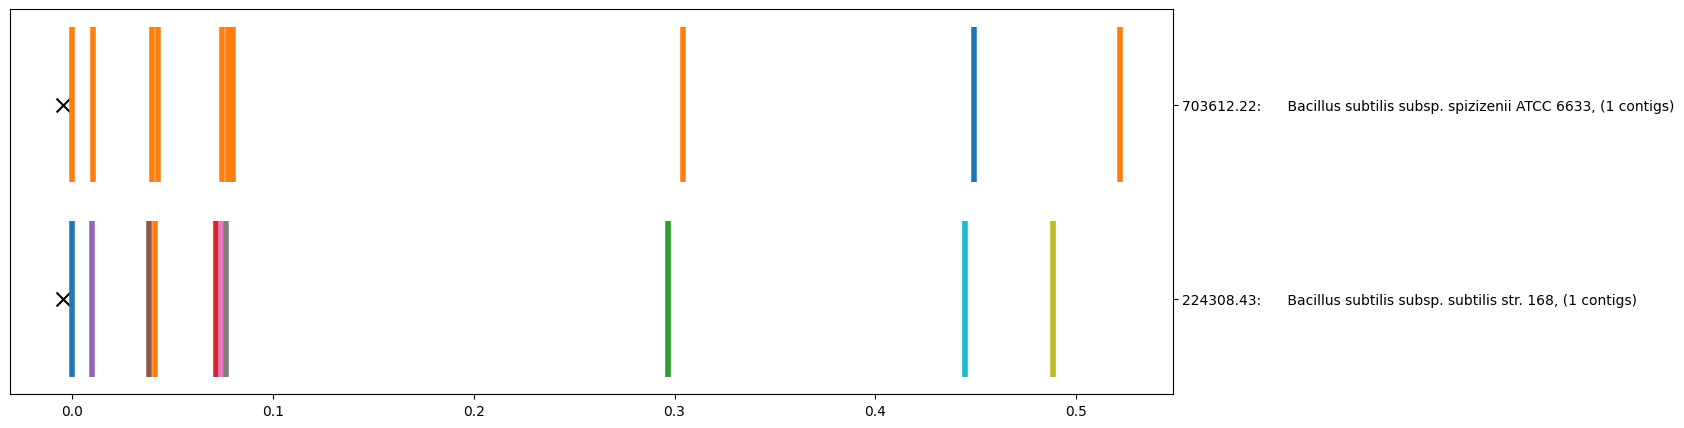

In [13]:
# Just Bacilli

# Filter to complete genomes and print count of remaining genomes
db_filtered2 = db_unfiltered.db[db_unfiltered.db["genome_name"].str.contains("Bacillus subtilis")]
print(len(db_filtered2["genome"].unique()))

# Get spreads
best_spreads2 = (
    db_filtered2["oor_distance"].groupby(db_filtered2["genome"]).apply(lambda x: x.max() - x.min()).sort_values(ascending=False)
)

# Plot
fig, ax = plt.subplots(figsize=(15, 5))
for i, gid in enumerate(best_spreads2.index):
    visualize_genome(gid, i, db_unfiltered[gid], db=db_unfiltered)

# Yticks on the right
plt.gca().yaxis.tick_right()
plt.yticks(
    np.arange(0, -len(best_spreads2), -1),
    [f"{gid}:\t{db_unfiltered[gid]['genome_name'].iloc[0]}, ({db_unfiltered[gid]['n_contigs'].iloc[0]} contigs)".expandtabs() for gid in best_spreads2.index],
)
plt.show()